# LLM Assignment 1: Representation Surgery (Coding)

Welcome to the coding part of the Representation Surgery question in Assignment 1.
The goal of this portion is to give you a deeper intuition for how representation surgery works and its strengths/limitations via hands-on implementations.

It consists of 2 parts:
1. Implementing linear concept erasure as described in the assignment, and applying it to a synthetic dataset.
2. Applying concept erasure to erase the concept of "gender" from the BERT representations of a dataset of biographies.

In this assignment, you'll have a series of tasks. For each task you will need to write some code and produce plots and/or accuracy results. You will need to export the notebook as a pdf and attach it to your submission. Please make sure all deliverables for each task (e.g., plots and accuracy results) are clearly visible, as we will be grading you on these outputs.

In [2]:
!git clone https://github.com/rycolab/llm-representation-surgery.git

fatal: destination path 'llm-representation-surgery' already exists and is not an empty directory.


In [1]:
# These are all the imports you should need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
np.random.seed(42)

e:\Anaconda\envs\PyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Constructing a synthetic dataset

First, we'll give you a synthetic dataset encoding a concept, i.e., the target labels.

In [24]:
n, d, k = 2048, 128, 2
X, Z = make_classification(
    n_samples=n,
    n_informative=k,
    n_features=d,
    n_classes=k,
    random_state=1,
)
print(f"Shape of X: {X.shape}, Shape of Z: {Z.shape}")

Shape of X: (2048, 128), Shape of Z: (2048,)


What does this dataset look like? Visualizing 128-dimensional data is hard, so we'll reduce the dimensionality to 2 using CCA and plot the result.

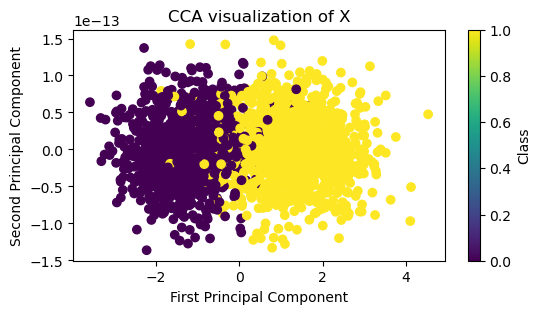

In [25]:
def plot_cca(X, Z):
    """
    Use Canonical Component Analysis to visualize the dataset X and label Z.
    """
    Z_one_hot = np.zeros((len(Z), len(set(Z))))
    Z_one_hot[np.arange(len(Z)), Z] = 1
    cca = CCA(n_components=2)
    X_cca = cca.fit_transform(X, y=Z_one_hot)[0]
    plt.figure(figsize=(6, 3))
    plt.scatter(X_cca[:, 0], X_cca[:, 1], c=Z, cmap='viridis')
    plt.colorbar(label='Class')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('CCA visualization of X')
    plt.show()

plot_cca(X, Z)

As you can see, in these two components, the two concepts are fairly separable.

### Task 0.1: Implement a logistic regression classifier predict the concept $Z$ from $X$.
FOR THE SUBMISSION: Print the accuracy your classifier scores on the data.

In [26]:
def logreg(X: np.ndarray, Z: np.ndarray) -> float:
    """
    Train a logistic regression classifier to predict concept Z from X.

    Args:
        X - the data
        Z - the concept/label

    Return:
        Accuracy in predicting Z from X.
    """
    # TODO:
    # Splot the data into training and testing sets
    X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.2, random_state=42)
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Initialize the logistic regression model
    model = LogisticRegression()
    # Train the model
    model.fit(X_train,Z_train)
    # Predict the labels for the test set
    Z_pred = model.predict(X_test)
    # Compute the accuracy
    accuracy = accuracy_score(Z_test,Z_pred)

    return accuracy

print(f"Accuracy before erasure: {logreg(X, Z):.3f}")

Accuracy before erasure: 0.905


## 1. Implementing linear concept erasure

### Task 1.1: Validate that the resulting whitening and unwhitening matrices satisfy their definition and goals.
That is, verify (a) $WW^{\top} =I$ and (b) $cov(XW) = I$.

FOR THE SUBMISSION: Include your plots showing the whitening matrices.

In [27]:
def compute_W(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the whitening and unwhitening matrix for the data using the ZCA whitening method
    (see Appendix A of https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf for more details).
    We give this to you as a numerically stable implementation.
    """
    sigma = np.cov(X.T)

    L, V = np.linalg.eigh(sigma)

    # Assuming PSD; account for numerical error
    L = L.clip(0.0)

    # Threshold used by torch.linalg.pinv
    mask = L > (L[-1] * sigma.shape[-1] * np.finfo(float).eps)

    with np.errstate(divide='ignore'):
      W = V * np.where(mask, 1/np.sqrt(L), 0.0) @ V.T
      W_inv = V * np.where(mask, np.sqrt(L), 0.0) @ V.T

    return W, W_inv

def heatmap(arr, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(arr, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

W, W_inv = compute_W(X)

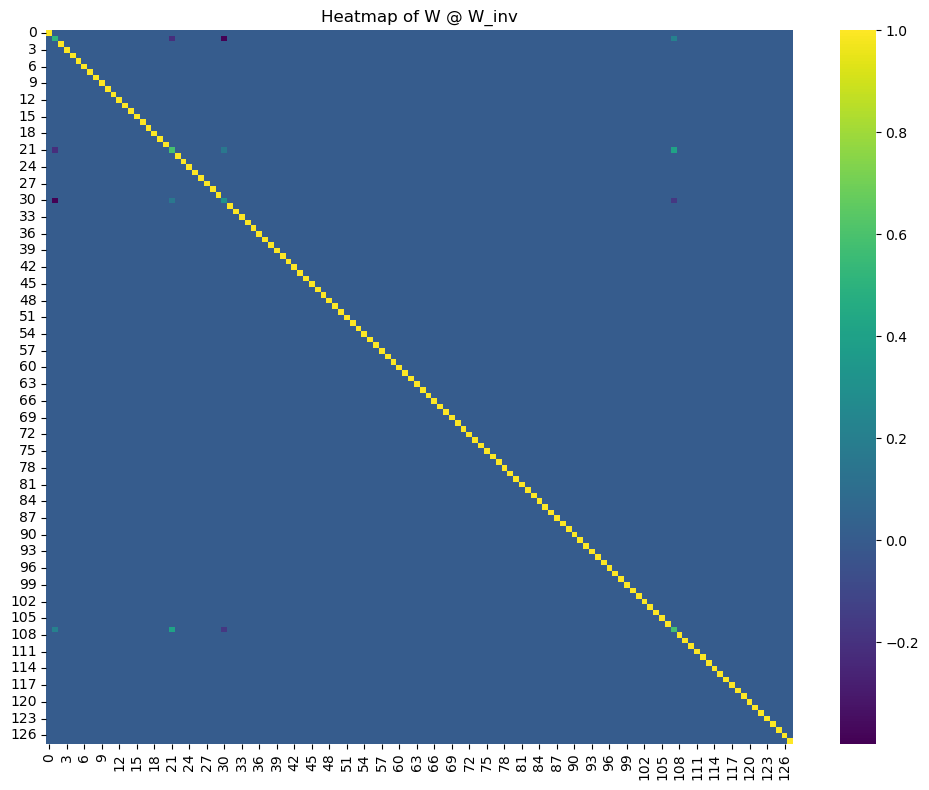

In [28]:
def verify_W_W_inv(W, W_inv):
    """
    Plot a heatmap of W @ W_inv to verify it satisfies the definition of whitening.
    """
    # TODO
    identity_approx = W @ W_inv
    heatmap(identity_approx, 'Heatmap of W @ W_inv')

verify_W_W_inv(W, W_inv)

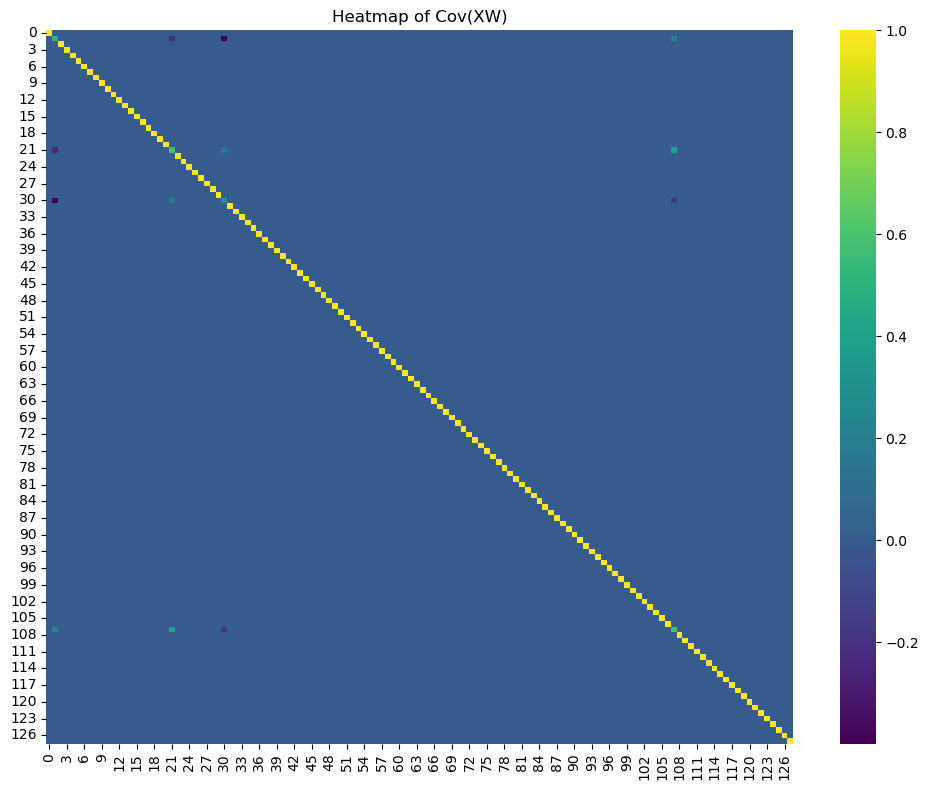

In [8]:
def verify_cov_XW(X, W):
    """
    Plot a heatmap of the covariance of XW to verify it satisfies the definition of whitening.
    """
    # TODO
    XW = X @ W
    cov_XW = np.cov(XW.T)
    heatmap(cov_XW, 'Heatmap of Cov(XW)')

verify_cov_XW(X, W)

### Task 1.2: Implement linear concept erasure
Use the equations derived from the written part of the assignment.

FOR THE WRITEUP: Include your plot and accuracy of the embeddings before erasure and after erasure.

In [29]:
def erase(X: np.ndarray, Z: np.ndarray) -> np.ndarray:
    """
    Implement linear concept erasure.

    Args:
        X - the data, shape (n, d)
        Z - the concept/label, shape (n,)

    Return:
        The data with the concept erased. Shape (n, d).
    """
    # TODO:
    # Get dimensions
    n, d = X.shape
    
    # Convert Z to one-hot encoding if it's categorical
    if np.issubdtype(Z.dtype, np.integer) or Z.dtype == bool:
        encoder = OneHotEncoder(sparse_output=False)
        Z_tilde = encoder.fit_transform(Z.reshape(-1, 1))
    else:
        # If Z is already continuous, reshape it
        Z_tilde = Z.reshape(n, -1)
    
    # Center X
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Compute covariance matrix of X
    Sigma_X_X = (X_centered.T @ X_centered) / n
    
    # Compute cross-covariance between X and Z
    Sigma_X_Z = (X_centered.T @ Z_tilde) / n
    
    # Calculate whitening matrix W = (Sigma_X_X^(1/2))^+
    # Using eigendecomposition for numerical stability
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma_X_X)
    # Add small constant to eigenvalues for numerical stability
    eigenvalues = np.maximum(eigenvalues, 1e-10)
    W = eigenvectors @ np.diag(1.0 / np.sqrt(eigenvalues)) @ eigenvectors.T
    
    # Compute the projection matrix in whitened space
    W_Sigma_X_Z = W @ Sigma_X_Z
    Pi_W_Sigma_X_Z = W_Sigma_X_Z @ np.linalg.pinv(W_Sigma_X_Z)
    
    # Apply transformation from equation (13): r(x) = x - W^+ Pi_W W (x - E[X])
    W_inv = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    
    # Apply transformation individually to maintain correct dimensions
    erased_X = np.zeros_like(X)
    for i in range(n):
        x_centered_i = X[i] - X_mean
        projection = W_inv @ Pi_W_Sigma_X_Z @ W @ x_centered_i
        erased_X[i] = X[i] - projection
    
    return erased_X
 

erased_X = erase(X, Z)

Now, let's validate that the concept has been erased.

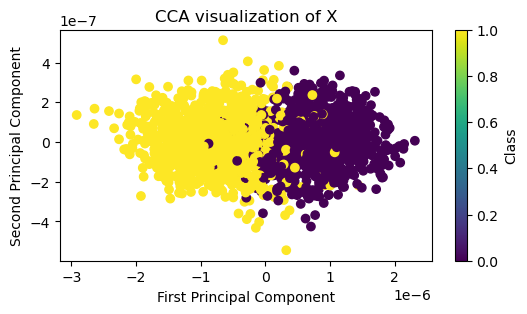

Accuracy after erasure: 0.2975609756097561


In [30]:
plot_cca(erased_X, Z)
print(f"Accuracy after erasure: {logreg(erased_X, Z)}")

## 2. Erasing gender bias
In this portion, we'll apply the same method to a real dataset of word embeddings of biography data. Your goal is to (a) construct sentence embeddings and (b) erase the gender concept from these embeddings. Use the **`hard_text_untokenized`** column for your embeddings.

In [31]:
df = pd.read_csv("llm-representation-surgery/data/biographies.csv")
df.head()

,g,p,text,start,hard_text,hard_text_untokenized,text_without_gender
0,f,psychologist,Brandi Smith is a registered psychologist in t...,139,Ms. Smith is experienced in providing psychoth...,Ms. Smith is experienced in providing psychoth...,_. _ is experienced in providing psychotherapy...
1,m,software_engineer,Duarte Nunes is a Software Engineer working on...,56,He has a background in concurrent programming ...,"He has a background in concurrent programming,...","_ has a background in concurrent programming, ..."
2,f,software_engineer,Lauren Ellsworth is a Senior Software Engineer...,139,"In her years of development , Lauren has contr...","In her years of development, Lauren has contri...","In _ years of development, _ has contributed t..."
3,f,professor,Gillian McCann is an Associate Professor in th...,124,She holds a doctorate in Religious Studies in ...,She holds a doctorate in Religious Studies in ...,_ holds a doctorate in Religious Studies in th...
4,m,professor,BIOGRAPHY: Jason Del Gandio (PhD) is an Assist...,113,His area of expertise is the theory and practi...,His area of expertise is the theory and practi...,_ area of expertise is the theory and practice...


### Task 2.1: Compute embeddings and use the `erase` function defined above to erase the gender concept from the embeddings.

FOR THE FOR THE SUBMISSION: Include:
(a) CCA plot of the embeddings before erasure,
(b) CCA plot of the embeddings after erasure,
(c) logistic regression accuracy before erasure, and
(d) logistic regression accuracy after erasure.

GPU is available: NVIDIA GeForce RTX 3050 Laptop GPU
Visualizing embeddings before erasure


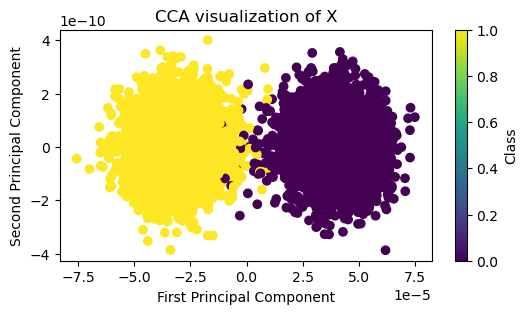

Accuracy before erasure: 0.996
Visualizing embeddings after erasure


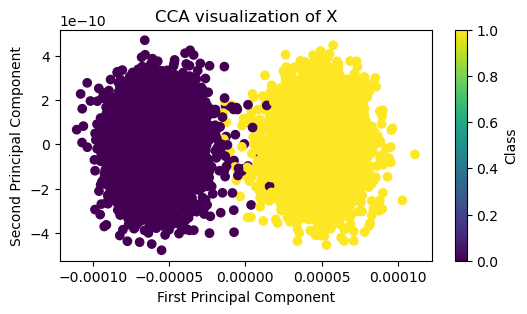

Accuracy after erasure: 0.352


e:\Anaconda\envs\PyTorch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    else:
        print("GPU is not available")

check_gpu()

def extract_gender_labels(df: pd.DataFrame) -> np.ndarray:
    """
    Extract the gender labels from the dataframe.
    """
    # TODO:
    gender_labels = df['g'].map({'f': 0, 'm': 1}).values
    return gender_labels

def compute_embeddings(df: pd.DataFrame) -> np.ndarray:
    """
    Compute the embeddings using a pretrained model for the "hard_text_untokenized" column of the given dataframe.
    Feel free to experiment with different models; a good starting point is the classic BERT model, "google-bert/bert-base-uncased".
    Also feel free to use any libraries which would be helpful, such as `transformers` or `sentence_transformers`.
    """
    # TODO:
    tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
    model = BertModel.from_pretrained('google-bert/bert-base-uncased').to('cuda')

    texts = df['hard_text_untokenized'].tolist()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to('cuda')
    embeddings = []
    batch_size = 16

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to('cuda')

        with torch.no_grad():
            outputs = model(**inputs)

        betch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(betch_embeddings)
    
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings
        

def erase_gender(embeddings: np.ndarray, gender_labels: np.ndarray) -> np.ndarray:
    """
    This function should do 3 things:
        1. Erase the gender concept from the embeddings and return these new embeddings.
        2. Visualize the embeddings before erasure and print the accuracy before erasure.
        3. Visualize the embeddings after erasure and print the accuracy after erasure.

    Args:
        embeddings: The embeddings to erase the gender concept from.
        gender_labels: The gender labels for the embeddings.

    Returns:
        The embeddings with the gender concept erased.
    """
    # TODO:
    # Visualize the embeddings before erasure
    print("Visualizing embeddings before erasure")
    plot_cca(embeddings, gender_labels)

    # Compute the accuracy before erasure
    accuracy_before = logreg(embeddings, gender_labels)
    print(f"Accuracy before erasure: {accuracy_before:.3f}")

    # Erase the gender concept
    erased_embeddings = erase(embeddings, gender_labels)

    # Visualize the embeddings after erasure
    print("Visualizing embeddings after erasure")
    plot_cca(erased_embeddings, gender_labels)   

    # Compute the accuracy after erasure
    accuracy_after = logreg(erased_embeddings,gender_labels)
    print(f"Accuracy after erasure: {accuracy_after:.3f}")

    return erased_embeddings
                              
gender_labels = extract_gender_labels(df)
embeddings = compute_embeddings(df)
embeddings_erased = erase_gender(embeddings, gender_labels)

### Task 2.2: Verifying minimally-destructive edits.
One key aspect of concept erasure is we want the edits to be *minimal*, i.e., they should not destroy other aspects of the representations. To test the degree to which the representation is preserved, use the profession as a proxy. Show that the profession information is preserved within the embeddings by computing the accuracy (a) before erasure and (b) after erasure.

FOR THE SUBMISSION: Report the accuracy before and after erasure.

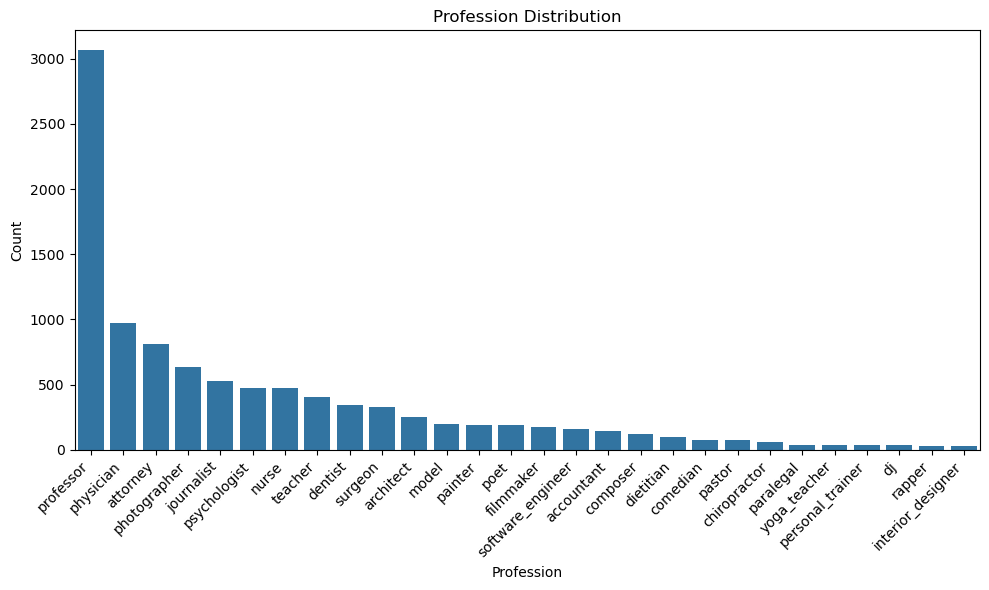

In [33]:
def visualize_profession(df: pd.DataFrame) -> np.ndarray:
    """
    Visualize the label distribution of professions, sorted from highest to lowest.
    """
    # TODO:
profession_counts = df['p'].value_counts()
profession_counts = profession_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=profession_counts.index, y=profession_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Profession')
plt.ylabel('Count')
plt.title('Profession Distribution')
plt.tight_layout()
plt.show()

visualize_profession(df)

In [35]:
def verify_profession_intact(embeddings: np.ndarray, embeddings_erased: np.ndarray, df: pd.DataFrame) -> np.ndarray:
    """
    Verify the profession information is preserved within the embeddings.
    """
    # TODO:
    # Extract the profession labels
    profession_labels = df['p'].values

    # Encode profession labels into integers
    profession_encoder = LabelEncoder()
    profession_labels = profession_encoder.fit_transform(profession_labels)

    # Compute the accuracy before erasure
    accuracy_before = logreg(embeddings, profession_labels)
    print(f"Accuracy before erasure: {accuracy_before:.3f}")

    # Compute the accuracy after erasure
    accuracy_after = logreg(embeddings_erased, profession_labels)
    print(f"Accuracy after erasure: {accuracy_after:.3f}")

verify_profession_intact(embeddings, embeddings_erased, df)

e:\Anaconda\envs\PyTorch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy before erasure: 0.736
Accuracy after erasure: 0.737


e:\Anaconda\envs\PyTorch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Task 2.3: Show that using a nonlinear classifier, you can recover the concept from the erased embeddings.

While we've successfully removed gender from being *linearly encoded* in the embeddings, they can still be extracted using other models. Your goal is to extract the concept using some other model.

FOR THE SUBMISSION: Report the accuracy before and after erasure.

In [42]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

def train_nn(model, criterion, optimizer,train_loader, val_loader, n_epochs=20):
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss/len(val_loader)}") 

def evaluate_nn(model, data_loader):
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        return accuracy 

In [43]:
def nonlinear_classifier(embeddings: np.ndarray, gender_labels: np.ndarray) -> float:
    """
    Train a nonlinear classifier on the embeddings to predict the gender labels and return the accuracy.
    """
    # TODO
    X_train, X_test, Z_train, Z_test = train_test_split(embeddings, gender_labels, test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(Z_train).float().unsqueeze(1))
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(Z_test).float().unsqueeze(1))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleNN(input_dim=embeddings.shape[1]).to('cuda')
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_nn(model, criterion, optimizer, train_loader, test_loader)
    accuracy = evaluate_nn(model, test_loader)
    return accuracy    

# Compute the accuracy before erasure
accuracy_before_nonlinear = nonlinear_classifier(embeddings, gender_labels)
print(f"Accuracy before erasure: {accuracy_before_nonlinear:.3f}")

# Compute the accuracy after erasure
accuracy_after_nonlinear = nonlinear_classifier(embeddings_erased, gender_labels)
print(f"Accuracy after erasure: {accuracy_after_nonlinear:.3f}")

Epoch 1/20, Validation Loss: 0.012344531899702454
Epoch 2/20, Validation Loss: 0.013380913893573933
Epoch 3/20, Validation Loss: 0.03855534849618192
Epoch 4/20, Validation Loss: 0.01202833400956089
Epoch 5/20, Validation Loss: 0.011847170970415592
Epoch 6/20, Validation Loss: 0.013253922268054412
Epoch 7/20, Validation Loss: 0.011307432893123146
Epoch 8/20, Validation Loss: 0.018190884054309294
Epoch 9/20, Validation Loss: 0.016429017890394398
Epoch 10/20, Validation Loss: 0.017534984260294997
Epoch 11/20, Validation Loss: 0.014508173754923822
Epoch 12/20, Validation Loss: 0.014146749529998719
Epoch 13/20, Validation Loss: 0.02334508813384045
Epoch 14/20, Validation Loss: 0.019230044701794936
Epoch 15/20, Validation Loss: 0.024632284030884775
Epoch 16/20, Validation Loss: 0.021290201166022277
Epoch 17/20, Validation Loss: 0.019993234528046442
Epoch 18/20, Validation Loss: 0.019579111556187367
Epoch 19/20, Validation Loss: 0.0201978657423501
Epoch 20/20, Validation Loss: 0.0206387668821